Images are currently in groups of 5  
&emsp;&emsp;0. Base image showing street view overlay  
&emsp;1-4. Horizon images spaced out 90 degrees from each other  
&emsp;&emsp;5. Sky image

The four horizon images will be the important ones. When wanting to identify
a set of pictures taken by a person later on that overlay won't be there,
and it seems the picture with the overlay lineas up with picture 4 in all
cases anyways.

The sky picture can also probably be dropped, I will try including it when
the different pictures form an extra dimention in the input layer, but if
I need to combine pictures 2-dimentionally then the sky picture will need
to be abandoned

In [1]:
from PIL import Image
import numpy as np

The goal here will be to load 5 images per index
Each image will be a 3d array, such that each value
in a 2d array is an array of three values corresponding
to red, green, and blue  
I'd like to add a fourth dimention of length 5, one for
each image. Also the dimentions of each image should 
probably be reduced to 256x256 or similar

This means the final shape of the input array would
end up at (5, 256, 256, 3)

JPEG
(1280, 1024)
RGB


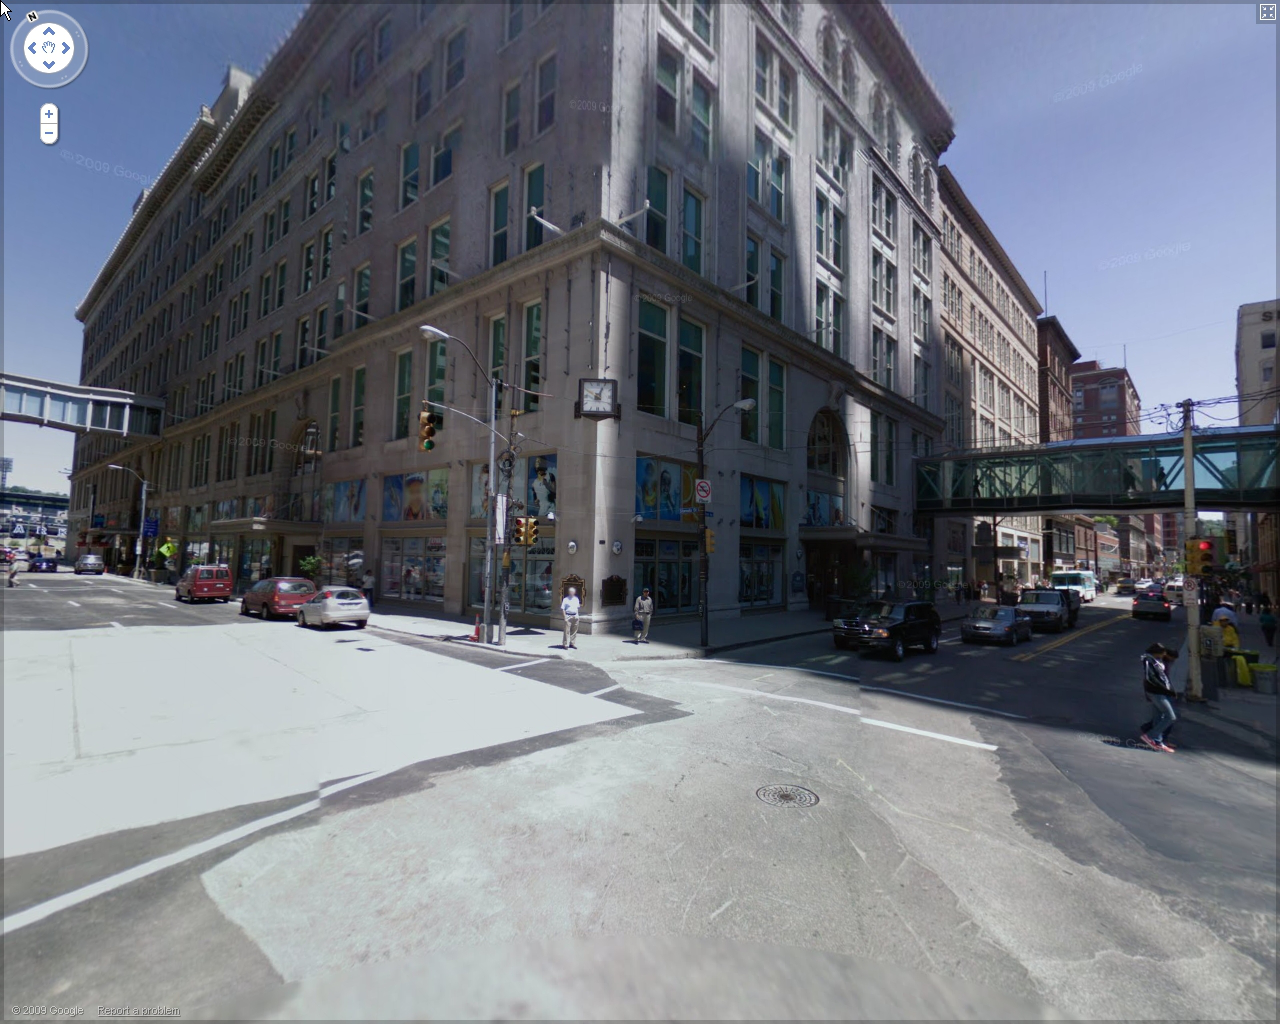

In [2]:
image = Image.open('data/images/000757_4.jpg')
print(image.format)
print(image.size)
print(image.mode)
image

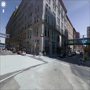

In [30]:
image.resize((90, 90))

In [33]:
def create_image_stack(imgid):
    # 4 images per location
    imgs = np.array([
        np.asarray(Image.open(
             f'data/images/{imgid:06}_{i}.jpg'
        ).resize((90, 90)))
        for i in range(1, 5)
    ])
    # Who knows if this will perform well but whatever
    return imgs.reshape(180, 180, 3)

create_image_stack(757).shape

(180, 180, 3)

In [41]:
import scipy.io as sio
imgcount = 10343
def create_batches(batchsize=32):
    # idk whether to do this inside or outside the function /shrug
    latlon = sio.loadmat('data/GPS_Long_Lat_Compass.mat')['GPS_Compass']
    # Do I want to do this randomly?
    for b in range(imgcount // batchsize):
        batch_begin = b * batchsize
        batch_end = min(imgcount, (b + 1) * batchsize)
        
        batch = np.array([
            create_image_stack(i + 1)
            for i in range(batch_begin, batch_end)
        ])
        # Only take the lat/lon, ignore compass direction
        targets = latlon[batch_begin:batch_end, 0:2]
        yield (batch, targets)

In [51]:
next(create_batches(1))[0].shape

(1, 180, 180, 3)

In [22]:
bcnt = 0
for _ in create_batches():
    bcnt += 1
    if bcnt % 30 == 0:
        print(f'Batch {bcnt}')
print(bcnt)

Batch 30
Batch 60
Batch 90
Batch 120
Batch 150
Batch 180
Batch 210
Batch 240
Batch 270
Batch 300
323


In [35]:
# Simple model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [43]:
model = Sequential()

model.add(Conv2D(64, 3, 3, input_shape=(180, 180, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# Prefetch might improve the performance, hopefully
# dataset = tf.data.Dataset.from_generator(
#     create_batches(),
#     output_types = tf.dtypes.DType()
# )
model.fit(
    repeat_generator(create_batches),
    steps_per_epoch = imgcount // 32,
    # dataset.prefetch(tf.data.AUTOTUNE),
    epochs = 2
)

Epoch 1/2
323/323 [==============================] - 1908s 6s/step - loss: 51.9721
Epoch 2/2
323/323 [==============================] - 1990s 6s/step - loss: 40.0273


In [57]:
model.predict(np.array([create_image_stack(757)]))

array([[ 37.608456, -68.39209 ]], dtype=float32)

In [54]:
def repeat_generator(genfunc, repeats=-1, **kwargs):
    # Numbers less than 0 will result in infinite repeats
    while repeats != 0:
        gen = genfunc(**kwargs)
        for res in gen:
            yield res
        repeats -= 1

In [58]:
model.save('models/initial_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/initial_model\assets
